In [1]:
import cv2

import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

In [2]:
# load a simple face detector
# !pip install retina-face
# !uv add retina-faceb
from retinaface import RetinaFace

2025-04-22 19:04:20.300958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745348660.314554  524811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745348660.318757  524811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745348660.331083  524811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745348660.331094  524811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745348660.331096  524811 computation_placer.cc:177] computation placer alr

In [3]:
%matplotlib inline

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))
print(tf.sysconfig.get_build_info()["cudnn_version"])

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]
9


In [6]:
print(tf.__version__)

2.19.0


In [7]:
# load Gaze-LLE model
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')
model.eval()
model.to(device)

Using cache found in /home/wangy79/.cache/torch/hub/fkryan_gazelle_main
Using cache found in /home/wangy79/.cache/torch/hub/facebookresearch_dinov2_main


GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features=10

In [ ]:

def extract_video_paths(data_folder, session_key):
    # iterate through folder to extract video and annotation files
    video_files = []
    for subj in os.listdir(data_folder):
        if os.path.isdir(os.path.join(data_folder, subj)):
            for sess in os.listdir(os.path.join(data_folder, subj)):
                if sess == session_key:
                    for file in os.listdir(os.path.join(data_folder, subj, sess)):
                        if file.endswith(".wmv"):
                            video_files.append(os.path.join(data_folder, subj, sess, file))
    return video_files
    
def convert_frame_to_images(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image)
    return image_pil

# visualize predicted gaze heatmap for each person and gaze in/out of frame score
def detect_eye_contact(heatmap, bboxes, width, height, normalize_heatmap):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize((width, height), Image.Resampling.BILINEAR)
    heatmap = np.asarray(heatmap).copy()
    if normalize_heatmap:
        heatmap = heatmap / np.sum(heatmap)
    scores = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        scores.append(np.sum(heatmap[int(ymin*height):int(ymax*height), int(xmin*width):int(xmax*width)]) / np.sum(heatmap))
    return scores

def rearrange_bbox_l2r(bboxes):
    # rearrange bboxes so it is from left to right on image
    bboxes = np.array(bboxes)
    order = np.argsort(bboxes[:, 0])
    bboxes = bboxes[order]
    return list(bboxes), order
    
    
def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(pil_image.size, Image.Resampling.BILINEAR)
    heatmap = plt.cm.jet(np.array(heatmap) / 255.)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert("RGBA")
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert("RGBA"), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline="lime", width=int(min(width, height) * 0.01))

        if inout_score is not None:
          text = "%.2f" % inout_score
          text_width = draw.textlength(text)
          text_height = int(height * 0.01)
          text_x = xmin * width
          text_y = ymax * height + text_height
          draw.text((text_x, text_y), text, fill="lime", font=ImageFont.load_default(size=int(min(width, height) * 0.05)))
    return overlay_image
# combined visualization with maximal gaze points for each person

def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    bboxes, l2r_order = rearrange_bbox_l2r(bboxes)
    heatmaps = heatmaps[l2r_order]
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=int(min(width, height) * 0.01))
        if inout_scores is not None:
            inout_score = inout_scores[i]
            other_bboxes = bboxes.copy()
            other_bboxes.pop(i)
            eye_contact_scores = detect_eye_contact(heatmaps[i], other_bboxes, width, height, normalize_heatmap=True)
            if i == 1: # TODO: eye contact is true as long as it is between child and others. Simplify this when no plotting needed
                children_eye_contact_score = max(eye_contact_scores)
            text = "%.2f" % inout_score + "\n" + "|".join(["%.2f" % score for score in eye_contact_scores])
            # text = "%.2f" % inout_score
            # text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text((text_x, text_y), text, fill=color, font=ImageFont.load_default(size=int(min(width, height) * 0.05)))

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse([(gaze_target_x-5, gaze_target_y-5), (gaze_target_x+5, gaze_target_y+5)], fill=color, width=int(0.005*min(width, height)))
            draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], fill=color, width=int(0.005*min(width, height)))
    
    if len(bboxes) < 3: # if parent, experimenter or children not in frame. if change this you need to reevalute how you pick the children bbox
        children_eye_contact_score = -1

    return overlay_image, children_eye_contact_score

def visualize_gaze_in_image(model, transform, images):
    gaze_scores = []
    overlay_images = []
    width, height = images[0].size
    print("Number of images:", len(images))
    print("Image size:", width, height)
    
    norm_bboxes = []
    img_tensors = []
    fail_indexes = []
    for i, image in enumerate(images):
        resp = RetinaFace.detect_faces(np.array(image), threshold=0.5)
        bboxes = [resp[key]['facial_area'] for key in resp.keys()]
        img_tensors.append(transform(image).unsqueeze(0).to(device))
        norm_bboxes.append([np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes])
        
    input = {
        "images": torch.cat(img_tensors, 0), # [num_images, 3, 448, 448]
        "bboxes": norm_bboxes # [[img1_bbox1, img1_bbox2...], [img2_bbox1, img2_bbox2]...]
    }
    print(norm_bboxes)
    print(len(norm_bboxes))
    
    with torch.no_grad():
        output = model(input)
        
        
    for i, image in enumerate(images):
        if i in fail_indexes:
            overlay_images.append(image)
            gaze_scores.append(-1)
        else:
            vis, score = visualize_all(image, output['heatmap'][i], norm_bboxes[i], output['inout'][i] if output['inout'] is not None else None, inout_thresh=0.5)
            overlay_images.append(vis)
            gaze_scores.append(score)
    
        # if plotting:
        #     for b in range(len(bboxes)):
        #         plt.figure()
        #         plt.imshow(visualize_heatmap(image, output['heatmap'][i][b], norm_bboxes[i][b], inout_score=output['inout'][[i]][b] if output['inout'] is not None else None))
        #         plt.axis('off')
        #         plt.show()
    
    return np.array(gaze_scores), overlay_images

def code_gaze_label(anns):
    labels = []
    for item in anns:
        if item == "eye contact":
            labels.append(1)
        elif item == "no eye contact":
            labels.append(0)
        else:
            break
    return np.array(labels)


def extract_frame_at_time(video_path, time_secs):
    imgs = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Cannot open video file")
    # Get the frames per second (fps)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = total_frames / fps
    print(f"Video FPS: {fps}, Total frames: {total_frames}, Duration: {duration_sec:.2f}s")

    for time_sec in time_secs:
        if time_sec > duration_sec:
            raise ValueError("Requested time exceeds video duration")
        # Calculate the frame index to extract
        frame_number = int(fps * time_sec)
        # Set the video position to the frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the frame
        ret, frame = cap.read()
        img = convert_frame_to_images(frame)
        imgs.append(img)
        if not ret:
            raise RuntimeError("Failed to read the frame at the specified time")
    cap.release()
    return imgs

In [30]:
video_file = "/Datasets/.Autism_Videos/data/bids/sub-2425/ses-18mo/sub-2425_ses-18mo_measure-CSBS_video.wmv"
vid = cv2.VideoCapture(video_file)

images = []
# vid = cv2.VideoCapture("/Datasets/.Autism_Videos/data/bids/sub-9943/ses-18mo/sub-9943_ses-18mo_measure-CSBS_video.wmv")
while True:
    vid.grab()
    retval, image = vid.retrieve()
    if not retval:
        break
    image_pil = convert_frame_to_images(image)
    images.append(image_pil)
vid.release()



In [10]:
len(images)

38176

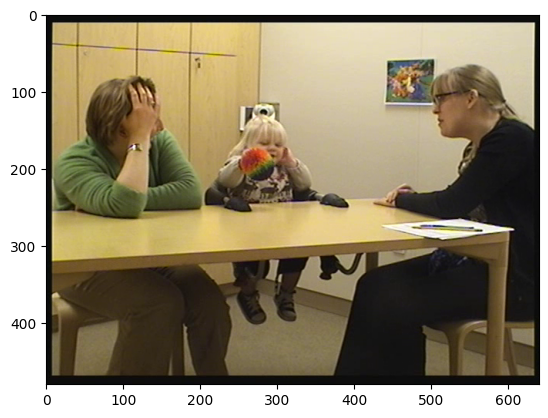

In [11]:
sample_image = images[1000]
plt.imshow(sample_image)

In [17]:
resp = RetinaFace.detect_faces(np.array(images[1000]))
print(resp)
bboxes = [resp[key]['facial_area'] for key in resp.keys()]

{'face_1': {'score': 0.9990506768226624, 'facial_area': [500, 86, 549, 159], 'landmarks': {'right_eye': [508.2933, 111.35681], 'left_eye': [511.96796, 109.436195], 'nose': [499.95703, 125.49598], 'mouth_right': [513.4492, 140.03265], 'mouth_left': [517.11566, 138.03043]}}}


Number of images: 1
Image size: 640 480
[[array([0.78125   , 0.17916667, 0.8578125 , 0.33125   ])]]
1
[-1]


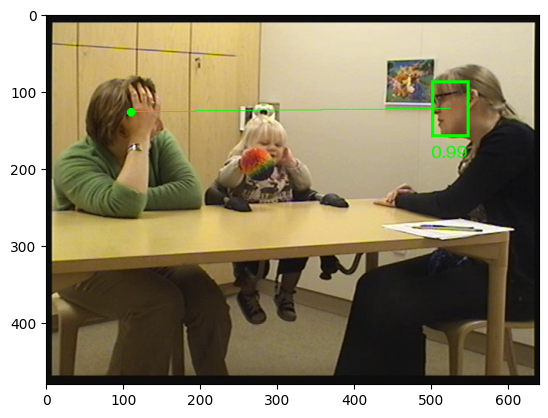

In [26]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [sample_image])
print(eye_contact_score)
plt.imshow(overlay[0])

Number of images: 1
Image size: 640 480
[[array([0.4265625 , 0.32083333, 0.4796875 , 0.41041667]), array([0.8890625 , 0.22291667, 0.978125  , 0.35416667]), array([0.11875   , 0.22708333, 0.203125  , 0.33541667])]]
1
[0.2935606]


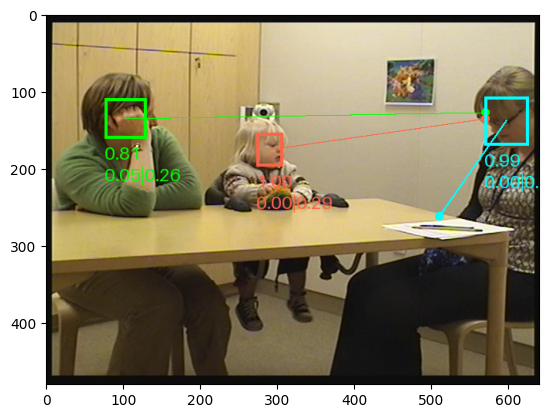

In [ ]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [images[2000]])
print(eye_contact_score)
plt.imshow(overlay[0])

Number of images: 1
Image size: 640 480
[[array([0.840625  , 0.1625    , 0.915625  , 0.30833333]), array([0.409375, 0.325   , 0.46875 , 0.4125  ])]]
1
[-1]


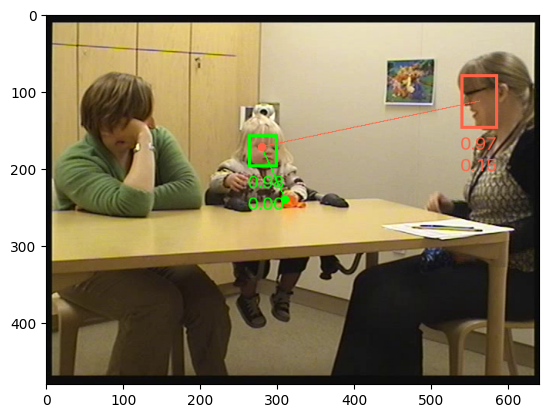

In [28]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [images[3000]])
print(eye_contact_score)
plt.imshow(overlay[0])

In [ ]:
import pandas as pd
annotation_file = video_file.replace("video.wmv", "coding.xlsx")
anns = pd.read_excel(annotation_file)
gaze_label = code_gaze_label(anns["EYE CONTACT"])
label_len = len(gaze_label) # get rid of the NaN values
begin_times = anns["Begin Time - ss.msec"][:label_len]
end_times = anns["End Time - ss.msec"][:label_len] 
sample_times = (begin_times + end_times) / 2
imgs = extract_frame_at_time(video_file, sample_times)
if label_len > 0:
    gaze_scores, overlay_images = visualize_gaze_in_image(model, transform, imgs)
    print(gaze_scores)
    print(gaze_label)
    accs.append(np.mean((gaze_scores>0.2).astype(int) == gaze_label))
    # TODO: calculate false positive and false negative